In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import GCRCatalogs
from GCRCatalogs import GCRQuery
import FoFCatalogMatching

import fitsio
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord

# Load Roman Detection Catalog

In [2]:
columns = ['ra', 'dec', 'magauto_H158']
roman_object = fitsio.read('../data/dc2_test_det_55.51_-39.9.fits.gz', columns=columns)
# Change column names for convenience
roman_object.dtype.names = ['ra', 'dec', 'mag_H']

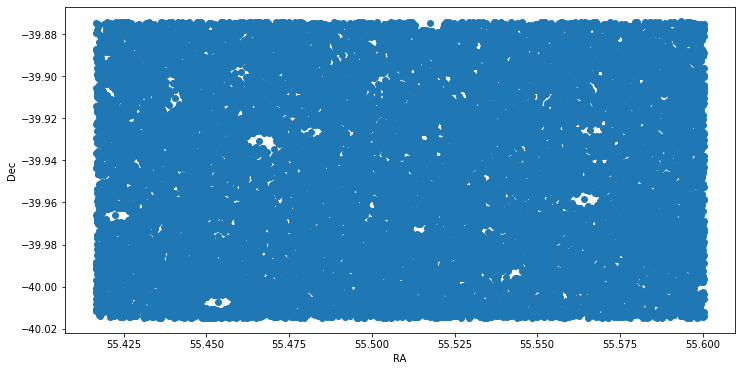

In [3]:
# Plot Roman detection area
min_ra, max_ra = np.min(roman_object['ra']), np.max(roman_object['ra'])
min_dec, max_dec = np.min(roman_object['dec']), np.max(roman_object['dec'])
fig = plt.figure(figsize=(12, 6))
plt.scatter(roman_object['ra'], roman_object['dec'])
plt.xlabel('RA')
plt.ylabel('Dec');

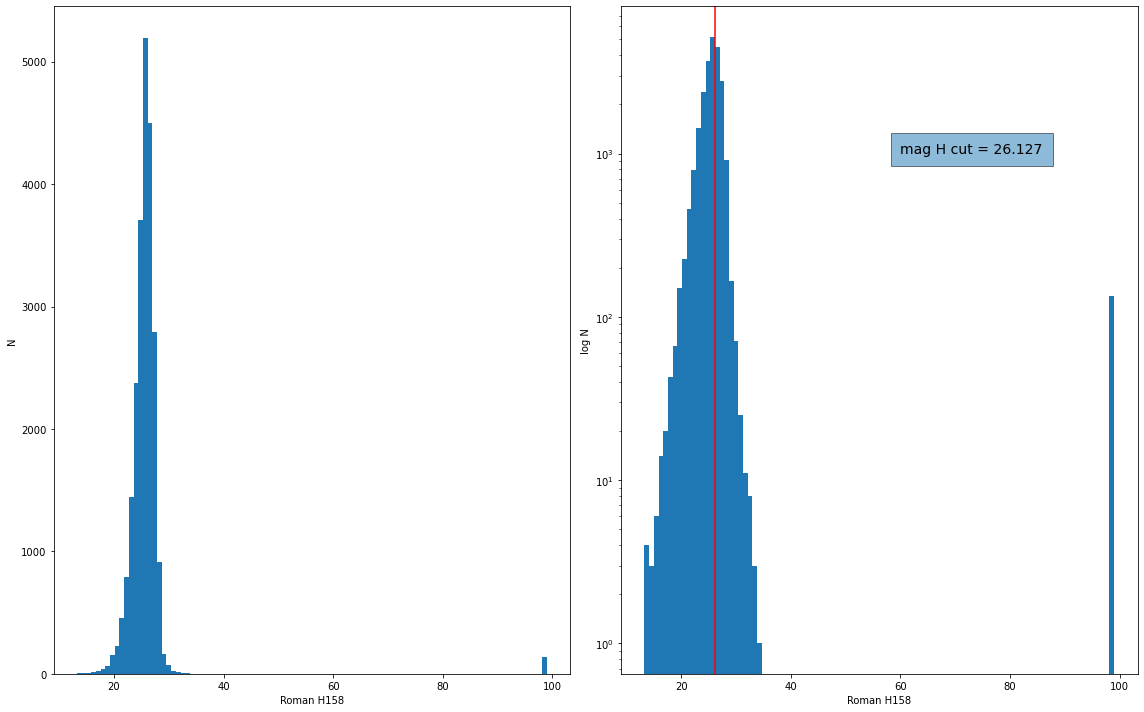

In [4]:
# Apply magnitude cut to Roman detection catalog
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
axs[0].hist(roman_object['mag_H'], bins=100)
axs[0].set_xlabel('Roman H158')
axs[0].set_ylabel('N')
roman_logN = axs[1].hist(roman_object['mag_H'], bins=100, log=True)
roman_maxN = np.argmax(roman_logN[0])
mag_H_cut = roman_logN[1][roman_maxN+1]
axs[1].axvline(mag_H_cut, c='red')
axs[1].set_xlabel('Roman H158')
axs[1].set_ylabel('log N')
axs[1].text(60, 1000, f'mag H cut = {mag_H_cut:.3f}', fontsize=14,
           bbox={'alpha': 0.5, 'pad': 10})
fig.tight_layout()

# Apply mag H cut
mag_H_mask = roman_object['mag_H'] < mag_H_cut
roman_object = roman_object[mag_H_mask]

# Build LSST Object Catalog 

In [5]:
# Load LSST object catalog from data/ else build it
lsst_file = 'lsst_object_test.ecsv'
if os.path.exists(f'../data/{lsst_file}'):
    lsst_object = Table.read(f'../data/{lsst_file}')
else:
    # Load LSST catalog
    lsst_cat = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6')
    # Apply filters
    basic_cuts = [
        GCRQuery('extendedness > 0'),
        GCRQuery((np.isfinite, 'mag_i')),
        GCRQuery('clean')
    ]
    pos_filters = [f'ra >= {min_ra}', f'ra <= {max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']
    # Get quantities using filters
    quantities = ['ra', 'dec', 'mag_i']
    lsst_object = lsst_cat.get_quantities(quantities,
                                        filters=basic_cuts+pos_filters)
    lsst_object = Table(lsst_object)
    lsst_object.write(f'../data/{lsst_file}')

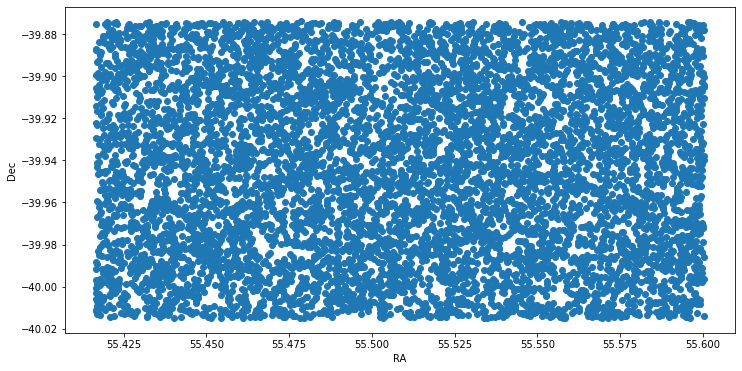

In [6]:
# Plot LSST detection area
fig = plt.figure(figsize=(12, 6))
plt.scatter(lsst_object['ra'], lsst_object['dec'])
plt.xlabel('RA')
plt.ylabel('Dec');

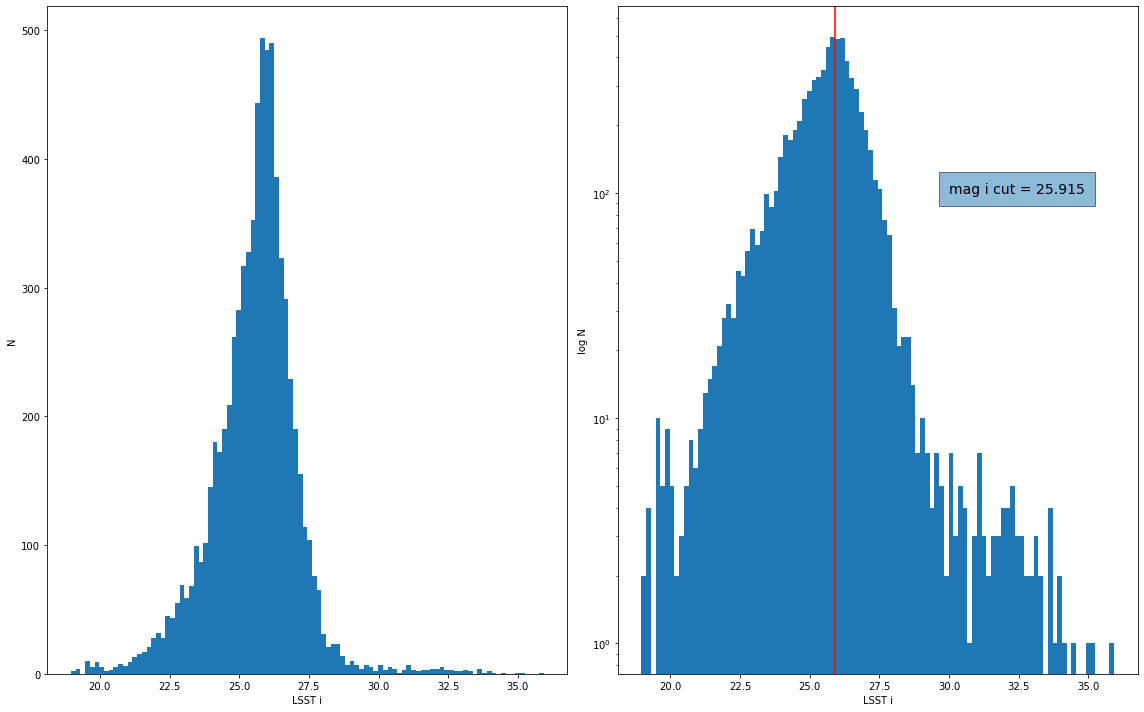

In [7]:
# Apply magnitude cut to LSST detection catalog
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
axs[0].hist(lsst_object['mag_i'], bins=100)
axs[0].set_xlabel('LSST i')
axs[0].set_ylabel('N')
lsst_logN = axs[1].hist(lsst_object['mag_i'], bins=100, log=True)
lsst_maxN = np.argmax(lsst_logN[0])
mag_i_cut = lsst_logN[1][lsst_maxN+1]
axs[1].axvline(mag_i_cut, c='red')
axs[1].set_xlabel('LSST i')
axs[1].set_ylabel('log N')
axs[1].text(30, 100, f'mag i cut = {mag_i_cut:.3f}', fontsize=14,
           bbox={'alpha': 0.5, 'pad': 10})
fig.tight_layout()

# Apply mag i cut
mag_i_mask = lsst_object['mag_i'] < mag_i_cut
lsst_object = lsst_object[mag_i_mask]

In [8]:
# Do the matching!
results = FoFCatalogMatching.match(
    catalog_dict={'lsst': lsst_object, 'roman': roman_object},
    linking_lengths=1.0
)

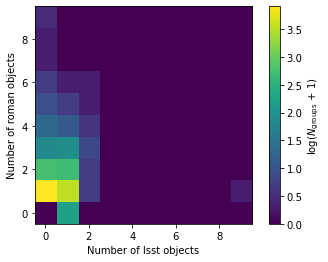

In [9]:
# Count the number of lsst and roman objects for each group
lsst_mask = results['catalog_key'] == 'lsst'
roman_mask = ~lsst_mask

# number of groups
n_groups = results['group_id'].max() + 1
n_lsst = np.bincount(results['group_id'][lsst_mask], minlength=n_groups)
n_roman = np.bincount(results['group_id'][roman_mask], minlength=n_groups)

# n_lsst and n_roman are the number of lsst/roman objects in each group
# Create a 2d histogram of (n_lsst, n_roman)
n_max = max(n_lsst.max(), n_roman.max()) + 1
hist_2d = np.bincount(n_roman * n_max + n_lsst, minlength=n_max*n_max).reshape(n_max, n_max)

plt.imshow(np.log10(hist_2d+1), extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower');
plt.xlabel('Number of lsst objects');
plt.ylabel('Number of roman objects');
plt.colorbar(label=r'$\log(N_{\rm groups} \, + \, 1)$');